In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras import layers,Sequential
from keras.layers import LSTM,Dropout,Dense

In [2]:
ACC = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [5]:
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()

In [6]:
print('ACC start: ',ACC_min_date,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date,'SleepL end: ',SleepL_max_date)

ACC start:  -124489.16105 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [7]:
ACC_new = ACC[(ACC['timedelta'] > ACC_min_date) &(ACC['timedelta'] < ACC_max_date) &(ACC['timedelta'] > HeartR_min_date) &(ACC['timedelta'] < HeartR_max_date)&(ACC['timedelta'] > SleepL_min_date) &(ACC['timedelta'] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR['timedelta'] > ACC_min_date) &(HeartR['timedelta'] < ACC_max_date) &(HeartR['timedelta'] > HeartR_min_date) &(HeartR['timedelta'] < HeartR_max_date)&(HeartR['timedelta'] > SleepL_min_date) &(HeartR['timedelta'] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL['timedelta'] > ACC_min_date) &(SleepL['timedelta'] < ACC_max_date) &(SleepL['timedelta'] > HeartR_min_date) &(SleepL['timedelta'] < HeartR_max_date)&(SleepL['timedelta'] > SleepL_min_date) &(SleepL['timedelta'] < SleepL_max_date)]

In [8]:
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], 'seconds').round('1s'))
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], 'seconds').round('1s'))
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], 'seconds').round('1s'))

In [9]:
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean()

In [10]:
ACC_new_2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1).reset_index()
ACC_new_2['timedelta'] = ACC_new_2['timedelta'] - ACC_new_2['timedelta'].min()

In [11]:
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [12]:
df_heartrate = HeartR_new.groupby('timedelta')['heartrate'].mean()

resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new_2 = pd.concat([HeartR_new2], axis=1).reset_index()
HeartR_new_2['timedelta'] = HeartR_new_2['timedelta']-HeartR_new_2['timedelta'].min()
HeartR_new_2

,timedelta,heartrate
0,0 days 00:00:00,97.0
1,0 days 00:00:01,97.0
2,0 days 00:00:02,97.0
3,0 days 00:00:03,97.0
4,0 days 00:00:04,97.0
...,...,...
16963,0 days 04:42:43,75.0
16964,0 days 04:42:44,75.0
16965,0 days 04:42:45,75.0
16966,0 days 04:42:46,75.0


In [13]:
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


In [14]:
df_SleepL = SleepL_new.groupby('timedelta')['sleep'].mean()
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new_2 = pd.concat([SleepL_new2], axis=1).reset_index()
SleepL_new_2['timedelta'] = SleepL_new_2['timedelta']-SleepL_new_2['timedelta'].min()
SleepL_new_2

,timedelta,sleep
0,0 days 00:00:00,-1.0
1,0 days 00:00:01,-1.0
2,0 days 00:00:02,-1.0
3,0 days 00:00:03,-1.0
4,0 days 00:00:04,-1.0
...,...,...
16916,0 days 04:41:56,0.0
16917,0 days 04:41:57,0.0
16918,0 days 04:41:58,0.0
16919,0 days 04:41:59,0.0


In [15]:
df_all = []
df_all = pd.merge_asof(ACC_new_2, HeartR_new_2, on='timedelta')
df_all = pd.merge_asof(df_all, SleepL_new_2, on = 'timedelta')
df_all

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,97.0,-1.0
1,0 days 00:00:01,-0.240757,0.873826,0.415446,97.0,-1.0
2,0 days 00:00:02,-0.244620,0.883943,0.387026,97.0,-1.0
3,0 days 00:00:03,-0.248036,0.902427,0.347812,97.0,-1.0
4,0 days 00:00:04,-0.241778,0.912946,0.321502,97.0,-1.0
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [16]:
df_all['sleep'] = df_all['sleep'].replace(-1,0)
df_all['heartrate'].fillna(df_all['heartrate'].median())
df_all['sleep'].fillna(0)
df_all = df_all.drop(columns='timedelta')

In [17]:
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
df_feature = df_all[feature_columns]
scaler = preprocessing.StandardScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature.values),index = df_feature.index,columns=df_feature.columns)
df_label = df_all[label_columns]

<AxesSubplot:>

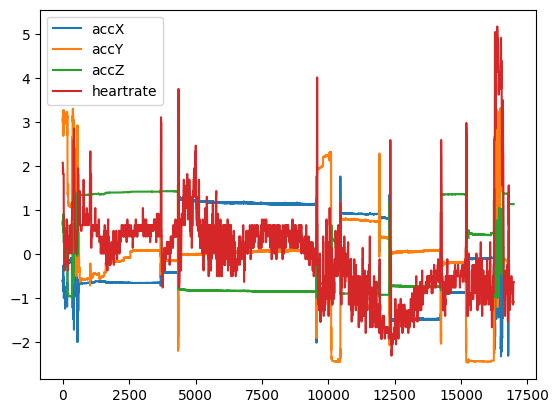

In [18]:
df_feature.plot.line()

<AxesSubplot:>

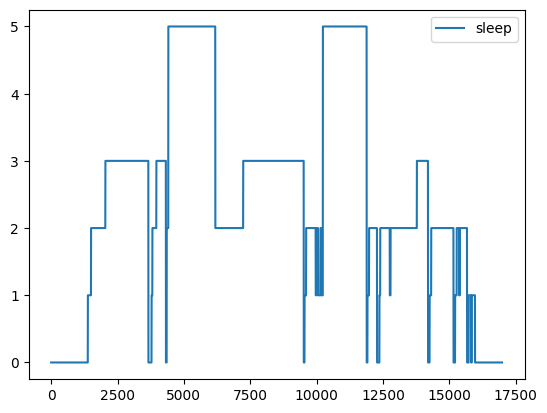

In [19]:
df_label.plot.line()

In [20]:
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,2.078705
1,-0.581456,2.995094,0.757746,2.078705
2,-0.591075,3.024668,0.722696,2.078705
3,-0.599581,3.078699,0.674335,2.078705
4,-0.583998,3.109450,0.641889,2.078705
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630035
16977,-1.082531,-1.095348,1.137542,-0.630035
16978,-1.081511,-1.094296,1.138273,-0.630035
16979,-1.083260,-1.096440,1.137363,-0.630035


In [21]:
df_label

,sleep
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
16976,0.0
16977,0.0
16978,0.0
16979,0.0


In [22]:
# ------------Simple Moving Average (SMA) ------------------------------
df_feature_SMA = pd.DataFrame()
columns=['accX', 'accY', 'accZ', 'heartrate']
df_feature_SMA['accX'] = df_feature['accX'].rolling(5, min_periods=1).mean()
df_feature_SMA['accY'] = df_feature['accY'].rolling(5, min_periods=1).mean()
df_feature_SMA['accZ'] = df_feature['accZ'].rolling(5, min_periods=1).mean()
df_feature_SMA['heartrate'] = df_feature['heartrate'].rolling(5, min_periods=1).mean()
print(df_feature_SMA)
print(df_feature)

           accX      accY      accZ  heartrate
0     -0.587547  3.058075  0.698728   2.078705
1     -0.584501  3.026584  0.728237   2.078705
2     -0.586693  3.025946  0.726390   2.078705
3     -0.589915  3.039134  0.713376   2.078705
4     -0.588732  3.053197  0.699079   2.078705
...         ...       ...       ...        ...
16976 -1.083093 -1.096081  1.137686  -0.630035
16977 -1.082878 -1.095794  1.137665  -0.630035
16978 -1.082621 -1.095441  1.137763  -0.630035
16979 -1.082981 -1.095685  1.137570  -0.630035
16980 -1.083198 -1.095884  1.137358  -0.630035

[16981 rows x 4 columns]
           accX      accY      accZ  heartrate
0     -0.587547  3.058075  0.698728   2.078705
1     -0.581456  2.995094  0.757746   2.078705
2     -0.591075  3.024668  0.722696   2.078705
3     -0.599581  3.078699  0.674335   2.078705
4     -0.583998  3.109450  0.641889   2.078705
...         ...       ...       ...        ...
16976 -1.084456 -1.096565  1.136974  -0.630035
16977 -1.082531 -1.095348  1.13754

In [23]:
# ------------ Train-Test-Split 2D features -------------------------------
# set sliding window parameter
slidingW = 100 #จ ํานวน row
Stride_step = 5
df_feature2D = np.array([])
df_label_new = np.array([])
df_feature2D_T = np.array([])
for t in range( 0 , len(df_feature), Stride_step ):
    F2d = np.array(df_feature[t:t+slidingW],ndmin=2)
    if len(F2d) <slidingW:
        break
    F2d_T = F2d.transpose()
    if df_feature2D.size == 0 :
        df_feature2D = F2d
        df_feature2D_T = F2d_T
    else:
        df_feature2D = np.dstack((df_feature2D,F2d))
        df_feature2D_T = np.dstack((df_feature2D_T,F2d_T))
    Labels = stats.mode(df_label[t : t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])
df_feature2D = np.swapaxes(df_feature2D,0,2)
df_feature2D_T = np.swapaxes(df_feature2D_T,0,2)
print(df_feature2D_T)
print(df_feature2D)

[[[-0.58754699  3.05807519  0.69872824  2.07870531]
  [-0.58145574  2.99509378  0.75774575  2.07870531]
  [-0.59107524  3.02466836  0.72269623  2.07870531]
  ...
  [-0.92104538  3.14574551  0.23209668  0.27287859]
  [-0.91866235  3.14714076  0.23126907  0.27287859]
  [-0.90930807  3.15256736  0.23283358  0.27287859]]

 [[-0.63079638  3.06967162  0.66802186  1.82073006]
  [-0.65623081  3.03358303  0.6929944   1.82073006]
  [-0.61745949  3.04996268  0.70392346  1.82073006]
  ...
  [-0.92642696  3.14347961  0.2498879   0.27287859]
  [-0.92573315  3.14479812  0.24662261  0.27287859]
  [-0.92884721  3.14333154  0.24502384  0.27287859]]

 [[-0.63628057  3.0250707   0.71564591  1.94971769]
  [-0.62761322  3.01867796  0.73035476  1.82073006]
  [-0.57525196  3.01737999  0.71955327  1.82073006]
  ...
  [-0.94121296  3.13656413  0.25052318  0.27287859]
  [-0.93930714  3.14278647  0.25643917  0.14389097]
  [-0.95057638  3.12620338  0.28615041  0.14389097]]

 ...

 [[-1.08102654 -1.09954191  1.1373

In [24]:
print(df_feature2D.shape)
print(df_feature2D_T.shape)
print(df_label_new.shape)

(3377, 4, 100)
(3377, 100, 4)
(3377,)


In [25]:
x_train, x_test, y_train, y_test = model_selection.train_test_split( df_feature2D, df_label_new, test_size = 0.3, random_state = 42)
x_train_T, x_test_T, y_train_T, y_test_T = model_selection.train_test_split( df_feature2D_T, df_label_new, test_size = 0.3, random_state = 42)

In [26]:
# ------------ LSTM Architecture parameter -------------------------------
# Nlayer (LSTM, dense), Nnode, Activation
LSTM_L1 = 100 # try 200, 300, 400, 500, 1000
LSTM_L2 = 50 # try 50, 100, 150, 200, 250, 300
dropRate_L1 = 0.25
dropRate_L2 = 0.5
D_out = 5
Activation = 'Softmax'
n_classes = 6
inRow = 4
inCol = slidingW
Input_shape_op1 = (inRow, inCol)
Input_shape_op2 = (inCol,inRow)

In [27]:
# ------------ Create LSTM Model -------------------------------
model = Sequential()
model.add(LSTM( LSTM_L1, return_sequences=True,input_shape= Input_shape_op1))
model.add(Dropout(dropRate_L1 ))
model.add(LSTM(LSTM_L2 ))
model.add(Dropout(dropRate_L2))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 100)            80400     
                                                                 
 dropout (Dropout)           (None, 4, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                                 
Total params: 110,906
Trainable params: 110,906
Non-trainable params: 0
_________________________________________________________________


In [28]:
# ------------ Create Optimizer -------------------------------
model.compile( optimizer='adam',loss='sparse_categorical_crossentropy',metrics=["acc"])
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(1014, 4, 100)
(1014,)
(2363, 4, 100)
(2363,)


In [29]:
# Training the model
EP = 50
batch_size = 60 # try 20, 40, 60, 80, 100
history = model.fit( x_train, y_train,batch_size = batch_size,validation_data=(x_test, y_test), epochs=EP)

Epoch 1/50
40/40 [==============================] - 21s 116ms/step - loss: 1.3542 - acc: 0.4888 - val_loss: 1.1055 - val_acc: 0.4931
Epoch 2/50
40/40 [==============================] - 1s 34ms/step - loss: 1.0792 - acc: 0.5612 - val_loss: 0.9213 - val_acc: 0.6499
Epoch 3/50
40/40 [==============================] - 1s 36ms/step - loss: 0.8871 - acc: 0.6576 - val_loss: 0.7325 - val_acc: 0.7022
Epoch 4/50
40/40 [==============================] - 1s 34ms/step - loss: 0.7517 - acc: 0.7105 - val_loss: 0.6088 - val_acc: 0.7821
Epoch 5/50
40/40 [==============================] - 1s 35ms/step - loss: 0.6503 - acc: 0.7402 - val_loss: 0.5370 - val_acc: 0.7909
Epoch 6/50
40/40 [==============================] - 1s 36ms/step - loss: 0.5717 - acc: 0.7749 - val_loss: 0.4666 - val_acc: 0.8028
Epoch 7/50
40/40 [==============================] - 1s 36ms/step - loss: 0.4942 - acc: 0.8100 - val_loss: 0.4068 - val_acc: 0.8560
Epoch 8/50
40/40 [==============================] - 1s 32ms/step - loss: 0.4366 -

In [30]:
# ------------ Create LSTM Model -------------------------------
model_t = Sequential()
model_t.add(LSTM( LSTM_L1, return_sequences=True,input_shape= Input_shape_op2))
model_t.add(Dropout(dropRate_L1 ))
model_t.add(LSTM(LSTM_L2 ))
model_t.add(Dropout(dropRate_L2))
model_t.add(Dense(n_classes, activation='softmax'))
model_t.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 100)          42000     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 306       
                                                                 
Total params: 72,506
Trainable params: 72,506
Non-trainable params: 0
_________________________________________________________________


In [31]:
# ------------ Create Optimizer -------------------------------
model_t.compile( optimizer='adam',loss='sparse_categorical_crossentropy',metrics=["acc"])

In [32]:
# Training the model
EP = 50
batch_size = 60 # try 20, 40, 60, 80, 100
history_t = model_t.fit( x_train_T, y_train_T,batch_size = batch_size,validation_data=(x_test_T, y_test_T), epochs=EP)

Epoch 1/50
40/40 [==============================] - 37s 615ms/step - loss: 1.2873 - acc: 0.4943 - val_loss: 0.9304 - val_acc: 0.6105
Epoch 2/50
40/40 [==============================] - 17s 427ms/step - loss: 0.9310 - acc: 0.6107 - val_loss: 0.7773 - val_acc: 0.6450
Epoch 3/50
40/40 [==============================] - 19s 467ms/step - loss: 0.7901 - acc: 0.6741 - val_loss: 0.6647 - val_acc: 0.7239
Epoch 4/50
40/40 [==============================] - 21s 529ms/step - loss: 0.7493 - acc: 0.6978 - val_loss: 0.7129 - val_acc: 0.7081
Epoch 5/50
40/40 [==============================] - 19s 470ms/step - loss: 0.8076 - acc: 0.6839 - val_loss: 1.0373 - val_acc: 0.6312
Epoch 6/50
40/40 [==============================] - 18s 442ms/step - loss: 0.8743 - acc: 0.6225 - val_loss: 0.6979 - val_acc: 0.6943
Epoch 7/50
40/40 [==============================] - 18s 443ms/step - loss: 0.7253 - acc: 0.6915 - val_loss: 0.7193 - val_acc: 0.6588
Epoch 8/50
40/40 [==============================] - 18s 454ms/step - 

In [33]:
LSTM_pred = np.argmax(model.predict(x_test),axis=1)

32/32 [==============================] - 5s 11ms/step


In [34]:
print('Confusion Matrix of LSTM_pred: ')
print(confusion_matrix(y_test, LSTM_pred))
print('Classification Report of LSTM_pred: ')
print(classification_report(y_test, LSTM_pred))

Confusion Matrix of LSTM_pred: 
[[167   6  13   0   0]
 [  1  39   7   0   2]
 [  7   5 285   7   7]
 [  0   0   7 270   0]
 [  0   0   4   0 187]]
Classification Report of LSTM_pred: 
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93       186
         1.0       0.78      0.80      0.79        49
         2.0       0.90      0.92      0.91       311
         3.0       0.97      0.97      0.97       277
         5.0       0.95      0.98      0.97       191

    accuracy                           0.93      1014
   macro avg       0.91      0.91      0.91      1014
weighted avg       0.94      0.93      0.93      1014



In [35]:
LSTM_pred_T = np.argmax(model_t.predict(x_test_T),axis=1)

32/32 [==============================] - 6s 99ms/step


In [36]:
print('Confusion Matrix of LSTM_pred transponse: ')
print(confusion_matrix(y_test_T, LSTM_pred_T))
print('Classification Report of LSTM_pred transponse: ')
print(classification_report(y_test_T, LSTM_pred_T))

Confusion Matrix of LSTM_pred transponse: 
[[152  21  13   0   0]
 [ 17  28   1   0   3]
 [ 11  25 257   6  12]
 [  0   0  19 258   0]
 [  0   1   8   0 182]]
Classification Report of LSTM_pred transponse: 
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       186
         1.0       0.37      0.57      0.45        49
         2.0       0.86      0.83      0.84       311
         3.0       0.98      0.93      0.95       277
         5.0       0.92      0.95      0.94       191

    accuracy                           0.86      1014
   macro avg       0.80      0.82      0.80      1014
weighted avg       0.88      0.86      0.87      1014



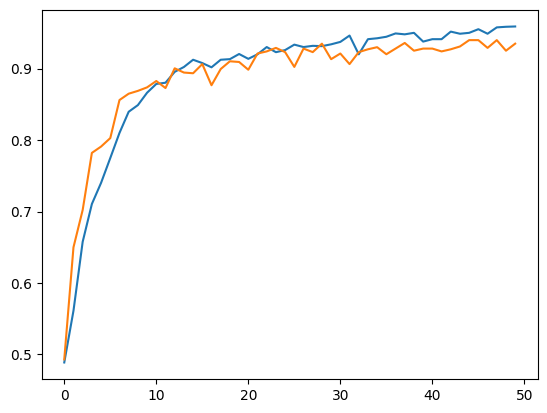

In [37]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph, Loss Graph
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

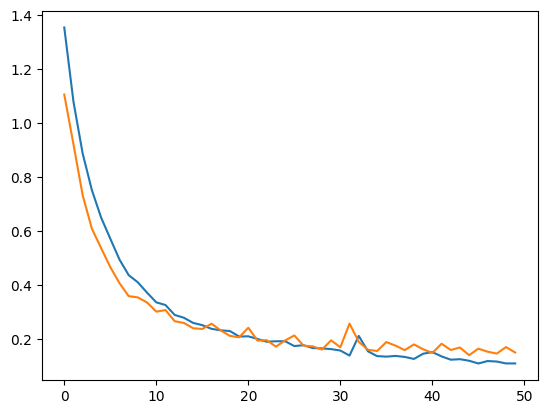

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

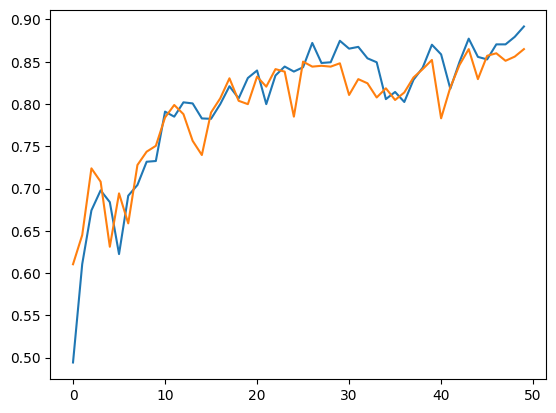

In [39]:
# ------ View History Graph -------------------------------------------
# View Accuracy Graph, Loss Graph
plt.plot(history_t.history['acc'])
plt.plot(history_t.history['val_acc'])

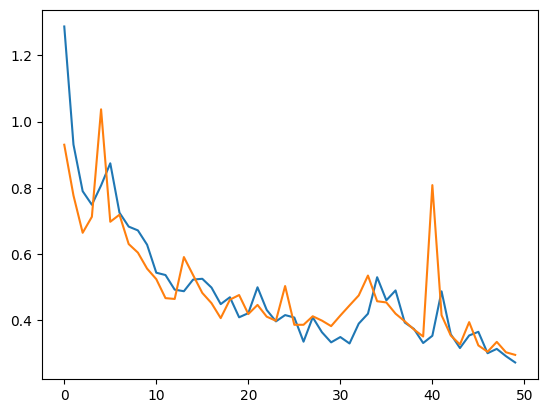

In [40]:
plt.plot(history_t.history['loss'])
plt.plot(history_t.history['val_loss'])